# Loading Annotations

In [2]:
import json

In [3]:
with open("annotations\instances_train2017.json") as jsonfile:
    data = json.load(jsonfile)

# Finding Images of People

Here, we are searching for all the annotations that are about a person and adding them to a list

In [4]:
personlist = []
for anno in data['annotations']:
    if (anno['category_id'] == 1):
        personlist.append(anno)
print(len(personlist))

262465


Here, we create a dictionary with image id as the key and the total area in pixels as the value. We use this later.

In [5]:
imagesizemap = {}
for img in data['images']:
    area = img['width']*img['height']
    imagesizemap[img['id']] = area
print(len(imagesizemap))

118287


Here, we collect the IDs of the Images that we want to use as well as the IDs of the annotations that we want to use.

In [6]:
goodidslist = set()
annlist=[]
for anno in personlist:
    if (anno['iscrowd']==1):
        continue
    w = anno['bbox'][2]
    h = anno['bbox'][3]
    area = w*h
    ratio = area/imagesizemap[anno['image_id']]*100
    if (ratio > 35 and ratio < 80):
        size = len(goodidslist)
        goodidslist.add(anno['image_id'])
        if (size != len(goodidslist)):
            annlist.append(anno['id'])

In [7]:
print(len(goodidslist))
print(len(annlist))

12827
12827


Finally we save the IDs to their respective files.

In [8]:
with open("imglist.txt", "w") as file:
    for i in goodidslist:
        file.write(str(i))
        file.write('\n')

In [9]:
with open("annlist.txt","w") as file:
    for i in annlist:
        file.write(str(i))
        file.write('\n')

# Creating training data

In [10]:
from __future__ import print_function
%matplotlib inline
from pycocotools.coco import COCO
import os, sys, zipfile
import urllib.request
import shutil
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Here, we initialize the COCO dataset API.

In [11]:
coco = COCO("annotations\instances_train2017.json")

loading annotations into memory...
Done (t=37.40s)
creating index...
index created!


Here, we read in the annotation IDs from the previously prepared file.

In [98]:
annlist = []
with open("annlist.txt", 'r') as anns:
    temp = anns.readlines()
    for i in temp:
        annlist.append(int(i))
print(len(annlist))

12827


Here, we load in the full annotations from the list of IDs. We then convert the annotations to masks with the COCO dataset API.

In [99]:
anns = coco.loadAnns(annlist)
annos = []
for anno in anns:
    annos.append(coco.annToMask(anno))
print(len(annos))

12827


Here, we get a list of the images that correspond to each of our annotations.

In [100]:
imglist = []
for anno in anns:
    imglist.append(anno['image_id'])
print(len(imglist))
imgs = coco.loadImgs(imglist)

12827


When we inspect the data, we should see an image and its corresponding mask:

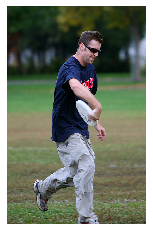

In [126]:
I = io.imread('images/%s'%(imgs[9710]['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()

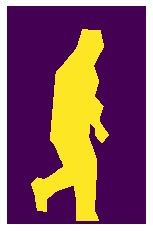

In [127]:
plt.axis('off')
plt.imshow(annos[9710])
plt.savefig('test.png')

Here, we filter through the dataset to make sure that all images have 3 channels. Some images had only one channel, and that caused me a lot of grief when i tried to train the model.

In [3]:
bad_img_ids = []
for i in range(len(imgs)):
    if (len(imgs)-1 < i):
        break
    b = io.imread('images/%s'%(imgs[i]['file_name']))
    if (len(b.shape) != 3):
        del imgs[i]
        del annos[i]
        i-=1
        bad_img_ids.append(img['id'])

# Training Data Generator

In [43]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

Here, we separate our data into train data and validation data.

In [148]:
val_size = 500 # This is around 5 percent of our total data

train_imgs = imgs[val_size:]
val_imgs = imgs[:val_size]

train_annos = annos[val_size:]
val_annos = annos[:val_size]

Here, we create our own custom data generator because of the way we parsed the COCO dataset images.

In [149]:
BATCH_SIZE = 8
IMG_SHAPE = 128

class DataGen(keras.utils.Sequence):
    def __init__(self, imgs, annos, batch_size=8, image_size=128):
        self.imgs = imgs
        self.annos = annos
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, index):
#         print(imgs[index]['id'])
        # Loading Images
        currImg = io.imread('images/%s'%(self.imgs[index]['file_name']))
        currMask = self.annos[index]
        
        # Resizing Images
        currImg = cv2.resize(currImg, (self.image_size, self.image_size))
        currMask = cv2.resize(currMask, (self.image_size, self.image_size))
        
        currImg = np.array(currImg)
        currMask = np.array(currMask)
        
        #Normalizing
        currImg = currImg/255.0
        currMask=currMask/255.0
        
        return currImg, currMask, self.imgs[index]['id']
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.imgs):
            self.batch_size = len(self.imgs) - index*self.batch_size
        
        batch_indices = np.arange(index*self.batch_size , (index+1)*self.batch_size)
        image = []
        mask  = []
        idds = []
        
        for ind in batch_indices:
            _img, _mask, imgID = self.__load__(ind)
            image.append(_img)
            mask.append(_mask)
            idds.append(imgID)
        try:
            image = np.array(image)
        except:
            for ia in idds:
                print(ia)
            for ia in image:
                plt.axis('off')
                plt.imshow(ia)
                plt.show()
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.imgs)/float(self.batch_size)))

In [79]:
gen = DataGen(train_imgs, train_annos, batch_size=BATCH_SIZE, image_size=IMG_SHAPE)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128)


# The UNet Model
Taken from https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow

In [70]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [75]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((IMG_SHAPE, IMG_SHAPE, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [76]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [150]:
train_gen = DataGen(train_imgs, train_annos, batch_size=BATCH_SIZE, image_size=IMG_SHAPE)
val_gen = DataGen(val_imgs, val_annos, batch_size=BATCH_SIZE, image_size=IMG_SHAPE)

train_steps = len(train_imgs)//BATCH_SIZE
val_steps = len(val_imgs)//BATCH_SIZE

epochs = 1
history = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=train_steps, validation_steps=val_steps, epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1538 steps, validate for 62 steps
1538/1538 [==============================] - 767s 499ms/step - loss: 0.0160 - acc: 0.7352 - val_loss: 0.0156 - val_acc: 0.7428


Finally, we can see how the model predicts an image:

In [157]:
model.save_weights("BackgroundRemove.h5")

x,y = val_gen.__getitem__(8)
result = model.predict(x)

In [ ]:
image_size=IMG_SHAPE
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")